In [65]:
import os
import librosa as liro
import librosa.display as lirod
import matplotlib
from matplotlib import pyplot as plt
import IPython.display as ipd
import torch 
import torch.nn as nn
import torchaudio
from scipy.fft import rfft, rfftfreq
import numpy as np

wd = os.getcwd()
os.chdir(os.path.join(wd, ".."))

from models.mel import AugmentMelSTFT
from datasets import audiodataset

os.chdir(wd)

example_data_path = os.path.join("..", "datasets", "example_data", "audio")
example_file = os.path.join(example_data_path, "mixkit-dog-barking-twice-1.wav")

# Today's Menu

- **Introduction to Pipeline**
    * Tips & Tricks for building an ML pipeline
    * Audio Preprocessing
    * Sample Project on GitHub
- **Questions**
- **Your reports**

# Introduction to Pipeline

## Tips & Tricks for building an ML pipeline

## Pipeline - Expectation


<center>
<img src="figs/expectation.jpg" alt="drawing" width="600"/>
</center>

## Pipeline - Reality

<center>
<img src="figs/reality.jpg" alt="drawing" width="600"/>
</center>

## Best Practices

* **document everything** (you in two weeks and your collegues should understand what you have done)
* be careful and maybe read things twice (bugs in your pipeline may cost you hours later on)
* **log everything**
* use **version control** - commit early, commit often

## Documentation

* keep a continuously updated **work log** - your colleagues should be able to quickly read up what you have done
* a well-written work log will save you a lot of time when writing your technical report
* put your worklog in version control (at least a google doc for collaborating with your colleagues)
* collect questions to us in your work log
* add enough comments to your code, **explaining "the why" of it**

## Version Control

* use git
* get familiar with it
* use one repo for code, one for work log
* when collaborating, use you own branches
* merge frequently

## Testing

run regular tests, in particular:
* **acquaintance tests**: get to know new library you don't know yet, allows to quickly learn new API, use e.g. a Jupyter Notebook
* **unit tests**: simple tests for your own functions (e.g. data augmentation functions)
* **integration tests**: more complex to test the interactions between your functions
* **validity tests**: manual inspection (e.g. by looking at computed spectrograms) to check if your code works as expected

**Try to verify each new code part in your group before you run full experiments with it.**

## Reproducibility

* **Code**: be aware of dependencies, use virtual environments (conda) and include frozen dependencies in version control
* **Training**: use a mother seed sequence to seed all pseudo random number generators (torch, numpy, python random, ...), log seed, log commit-hash
* **Data**: make preprocessing of data and labels repeatable

## Leakage

* **use the provided split for your task**!
* make sure **NO** aspects of your test data distribution are leaking intro your training or validation set
* e.g. leaking through normalization is a prominent case

<center>
<img src="figs/leakage.png" alt="drawing" width="600"/>
</center>

## Leakage across devices

* e.g. in DCASE Task 1, recording devices play an important role
* generalization performance to unseen devices should be measured
* make sure to use the provided split, splitting data paying no attention to the devices will give you a very wrong estimation of your actual test performance

<center>
<img src="figs/leakage_devices.png" alt="drawing" width="600"/>
</center>

## Audio Preprocessing

## Overview

audio is processed (amost exclusively) as **spectrograms**. 

Common preprocessing steps (see provided example pipeline) involves:

* Pre-emphasis: time-domain finite impulse response (FIR) filter to modify average spectral shape
* **Short Time Fourier Transform**: convert time domain signal into time-frequency domain
* Calculate **magnitude** (absolute value) or **power** (squared values) spectrogram
* Apply a **mel filterbank** to the spectrogram
* Use logarithm $\rightarrow$ **log mel spectrogram** to match human perception of loudness

## Our Starting Point

* **Sound**: variation in air pressure at a point in space, as a function of time
* Microphone turns mechanical energy of a soundwave into an electrical signal
* Analog signal is converted into digital signal in two steps: **discretization at regular time intervals**, **quantization/rounding** each sample to a fixed set of values


<center>
<img src="figs/digitized_signal.png" alt="drawing" width="300"/>
</center>

## The sampling theorem

* **a continuous (analog) signal can be properly sampled, only if it does not contain frequency components above one-half of the sampling rate**
* from a **properly sampled** signal, we can reconstruct the original signal
* e.g. for a signal sampled at 44100 Hz, the **nyquist frequency** is 22050 Hz 
* frequencies above $\frac{1}{2}$ of the sampling rate are aliased into frequencies that can be represented in the digitized signal $\rightarrow$ **information loss** 
* use analog low pass filter before sampling

## Digital Filters

* digital filters are fundamental for digital audio processing
* can be used in time or frequency domain
* can be used to separate mixed signals, restore clean from distorted signals
* are characterized by their **impuls/frequency reponse**
* finite and inifinite impuls reponse filters (FIR, IIR)
* **FIR filters implemented using convolution with impuls response**
* see **pre-emphasis filter** in example pipeline

## Discrete Fourier Transform

* Fourier Analysis for **discrete time, discrete frequency, periodic** signals
* we pretend our digitized signal repeats inifintely often in both directions 
* commonly the Fourier Transform is defined in the complex domain

$$X[k]=\frac{1}{N} \sum_{n=0}^{N-1}x[n] \mathrm{e}^{\dfrac{-2\pi k i n}{N}}$$

* using Euler's formula $e^{ix}=\cos x + i \sin x$, we can think of the frequency domain as a set of sine and cosine wave amplitudes

$$X[k]=\frac{1}{N} \sum_{n=0}^{N-1} \underbrace{x[n] \cos(\frac{-2\pi k n}{N})}_{\textrm{real part}} + \underbrace{i x[n] \sin(\frac{-2 \pi k n}{N})}_{\textrm{imaginary part}}$$

## Discrete Fourier Transform

Output of the DFT are the values of the coefficients for the basis functions in the frequency domain.

<center>
<img src="figs/basis.png" alt="drawing" width="400"/>
</center>

## Discrete Fourier Transform

* time domain signal runs from $0$ to $N-1$
* translates to $\frac{N}{2} + 1$ sine (imaginary) and cosine (real) amplitudes
* DFT can be computed by matrix multiplication with basis function ($O(N^2)$)
* ... or much faster using **FFT** ($O(N log N)$)

<center>
<img src="figs/DFT.png" alt="drawing" width="500"/>
</center>

## Magnitude and Phase

* Cosine and Sine wave amplitudes can be converted to **polar form**:
* **Magnitude**: $Mag X[k] = \sqrt{(Re X[k])^2 + (Im X[k])^2}$
* **Phase**: could be computed, but the magnitude is what we are usually interested in
* In a magnitude spectrum, the **magnitude of a bin $X[k]$ is the sum of all energy in its frequency band**

## Frequency Resolution

* N-point FFT (N usually chosen as a power of two, signal is zero padded) results in spectrum with $\frac{N}{2} + 1$ frequency bins
* bins are equally spaced in the range $[0, \frac{S}{2}]$ Hertz (S is sampling rate)
* the frequency resolution (in Hertz) is $r \approx \frac{S}{N}$
* can **reduce inter-sample spacing in frequency domain by zero padding** (increase resolution in frequency domain)

<center>
<img src="figs/zero_padding.png" alt="drawing" width="600"/>
</center>

## Spectral Leakage and Windowing

* DFT assumes a periodic signal $\rightarrow$ our time-domain signal is implictly repeated

<center>
<img src="figs/signal_repeated.png" alt="drawing" width="800"/>
</center>

* a sine NOT matching a basis function will be cut at the border, **explaining this cut requires all the basis functions**


<center>
<img src="figs/spectral_leakage.png" alt="drawing" width="400"/>
</center>

## Spectral Leakage and Windowing

* signals can be multiplied with a window to **avoid hard cuts at the borders**
* results in comparable peaks for sines matching or not matching a basis function
* popular windows: Hann, Hamming, Gaussian ... (trade-off main lobe and side lobes)

<center>
<img src="figs/windowing.png" alt="drawing" width="600"/>
</center>

## Short-Time Fourier Transform

* computing DFT of the whole audio clip, we **loose all timing information**
* audio clip is cut up in **overlapping frames** and **DFT is computed per frame**
* **window length**: make frames long enough to have a **useful frequency resolution** and short enough such that the **signal is stationary within a frame**

<center>
<img src="figs/stft.png" alt="drawing" width="400"/>
</center>

## Mel Spectrogram

* we usually **apply additional filterbanks** on the spectrogram computed by STFT
* can be viewed as a matrix multiplication: $\mathrm{torch.matmul(filterbank, spectrogram)}$
* want to **decrease dimensionality** and filter out relevant audio features for task $\rightarrow$ idea is to model human perception
* humans don't perceive frequencies on a **linear scale**; **detecting differences in lower frequencies is easier than in higher frequencies**
* want to have higher resolution in low frequency regions, lower resolution in high frequency regions
* **Mel scale**: equal distances in pitch sounds equally distant to listeners

## Mel Spectrogram

<center>
<img src="figs/mel_filterbank.png" alt="drawing" width="600"/>
</center>

In [3]:
def wav_plot(x, sr, listen=True, title=""):
    fig, ax = plt.subplots(nrows=1, figsize=(10, 2))
    ax.set_title(title)
    lirod.waveshow(x, sr=sr, ax=ax, x_axis='s')
    plt.show()
    if listen:
        audio = ipd.Audio(x, rate=sr)
        ipd.display(audio)

In [4]:
def freq_plot(x, sr, title="", n=1024):
    x_mag = np.abs(rfft(x, n=n))
    x_mag = liro.amplitude_to_db(x_mag)
    freqs = rfftfreq(n, 1 / sr)
    fig, ax = plt.subplots(nrows=1, figsize=(10, 2))
    ax.set_title(title)
    ax.plot(freqs, x_mag)
    ax.set_xscale('symlog', base=2)
    ax.set_xlabel("Frequency (Hertz)")
    ax.set_ylabel("Amplitude (db)")
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.show()

In [250]:
def spec_liro(x, sr, n_fft=1024, win_length=800, hop_length=320, x_is_spec=False,
              x_is_power_spec=False, x_is_mel_spec=False, convert_to_db=True, title="Spectrogram"):
    fig, ax = plt.subplots(nrows=1, figsize=(10, 2))
    ax.set_title(title)
    if x_is_mel_spec:
        x_is_power_spec = True
        x_is_spec = True
    if x_is_power_spec:
        x_is_spec = True
    if not x_is_spec:
        x = liro.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
        x, phase = liro.magphase(x)
    if convert_to_db:
        if x_is_power_spec:
            # power spectrogram 
            x = liro.power_to_db(x)
        else:
            # magnitude spectrogram
            x = liro.amplitude_to_db(x) 
    img = lirod.specshow(
        x,
        sr=sr,
        x_axis='s',
        y_axis='mel' if x_is_mel_spec else 'log',
        cmap='magma',
        ax=ax,
        n_fft=n_fft,
        win_length=win_length
    )
    fig.colorbar(img, ax=ax, format='%+2.0f dB' if convert_to_db else None)
    plt.show()

## Our Starting Point - a waveform

... a dog barking

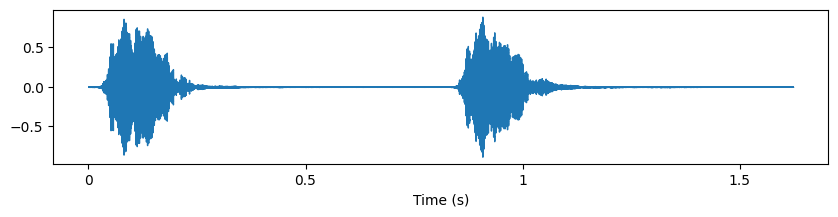

In [251]:
sr = 32000 
example_wav, _ = liro.load(example_file, sr=sr)
wav_plot(example_wav, sr)

## Apply Pre-emphasis (Digital Filter)

* Majority of energy is concentrated in the lower end of the spectrum (drops around 2 dB/kHz)
* Pre-emphasis **compensates for the average spectral shape** and **emphasises higher frequencies**
* implemented as **time-domain FIR**

In [252]:
preemphasis_coefficient = torch.as_tensor([[[-.97, 1]]])
wav_torch = torch.from_numpy(example_wav)
wav_pree = nn.functional.conv1d(wav_torch.reshape(1, 1, -1), preemphasis_coefficient).squeeze(1)

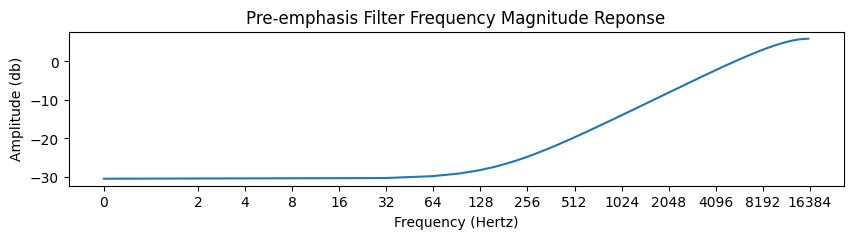

In [253]:
freq_plot(preemphasis_coefficient.squeeze().numpy(), sr, title="Pre-emphasis Filter Frequency Magnitude Reponse")

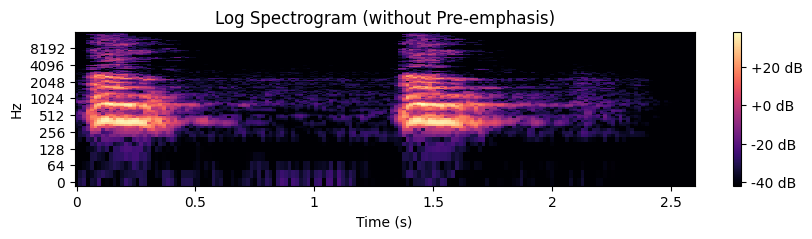

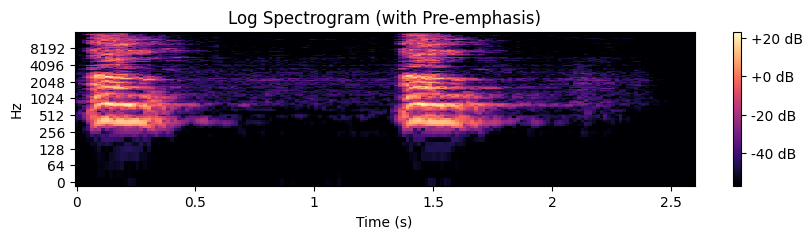

In [254]:
spec_liro(example_wav, sr, title="Log Spectrogram (without Pre-emphasis)")
spec_liro(wav_pree.squeeze().numpy(), sr, title="Log Spectrogram (with Pre-emphasis)")

## STFT


In [255]:
n_fft, win_length, hop_length = 1024, 800, 320 
window = torch.hann_window(win_length, periodic=False)
spec = torch.stft(wav_pree, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
                       center=True, normalized=False, window=window, return_complex=False)
power_spec = (spec ** 2).sum(dim=-1)
# for comparison, we calculate also the magnitude spectrogram
mag_spec = torch.sqrt(power_spec)

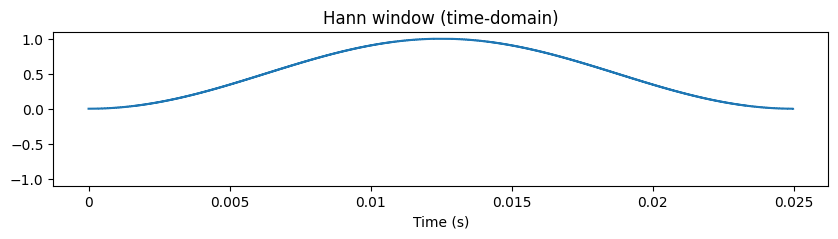

In [256]:
wav_plot(window.squeeze().numpy(), sr, listen=False, title="Hann window (time-domain)")

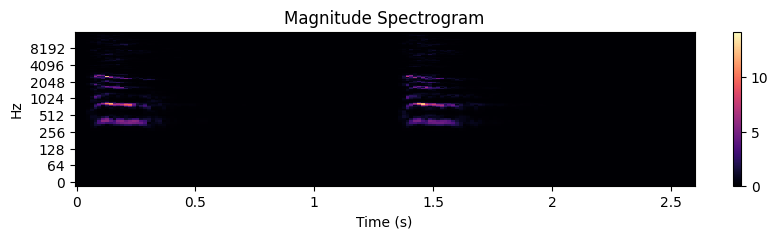

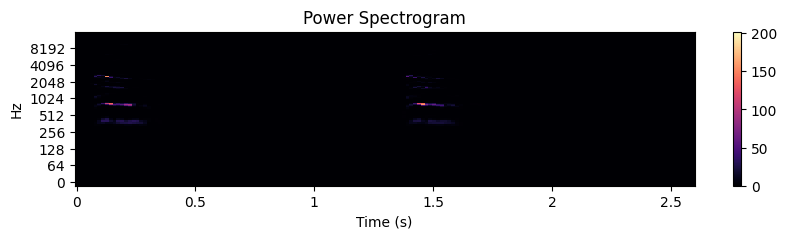

In [257]:
spec_liro(mag_spec.squeeze().numpy(), sr, x_is_spec=True, convert_to_db=False, title="Magnitude Spectrogram")
spec_liro(power_spec.squeeze().numpy(), sr, x_is_power_spec=True, convert_to_db=False, title="Power Spectrogram")

## Mel Transformation

In [258]:
n_mels, fmin, fmax = 40, 0.0, sr // 2
mel_basis, _ = torchaudio.compliance.kaldi.get_mel_banks(n_mels, n_fft, sr,
                                                                 fmin, fmax, vtln_low=100.0, vtln_high=-500.,
                                                                 vtln_warp_factor=1.0)
# pad with one zero per mel bin to match n_fft // 2 + 1
mel_basis = torch.as_tensor(torch.nn.functional.pad(mel_basis, (0, 1), mode='constant', value=0))

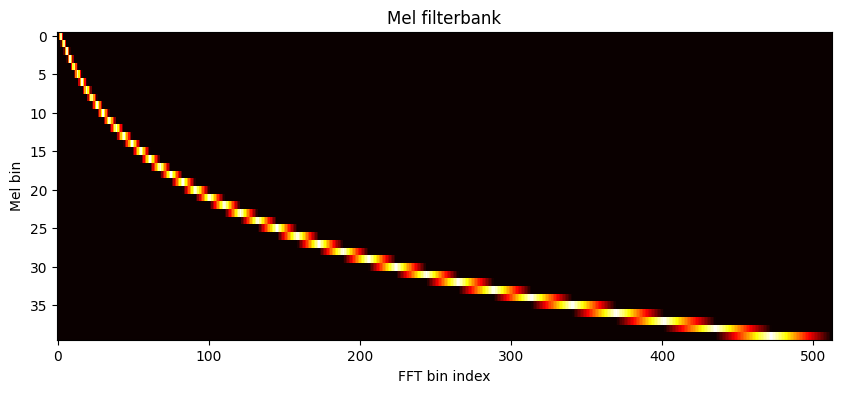

In [259]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 4))
ax.set_title("Mel filterbank")
ax.set_xlabel("FFT bin index")
ax.set_ylabel("Mel bin")
ax.imshow(mel_basis.squeeze().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

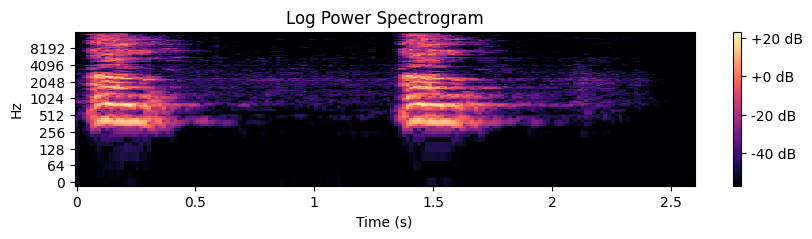

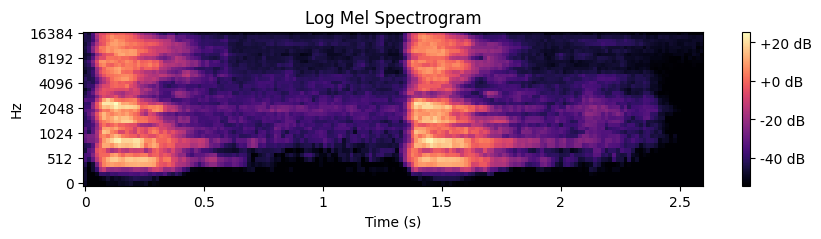

In [260]:
melspec = torch.matmul(mel_basis, power_spec)
spec_liro(power_spec.squeeze().numpy(), sr, x_is_power_spec=True, title="Log Power Spectrogram")
spec_liro(melspec.squeeze().numpy(), sr, x_is_mel_spec=True, title="Log Mel Spectrogram")

##  Why the 'Log'?

We compute the logarithm to match human perception again - we perceive the loudness of sound logarithmically with respect to its intensity.

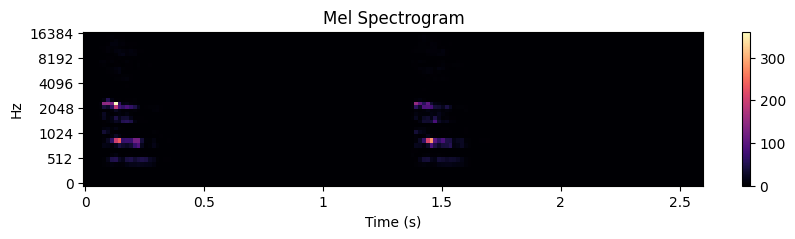

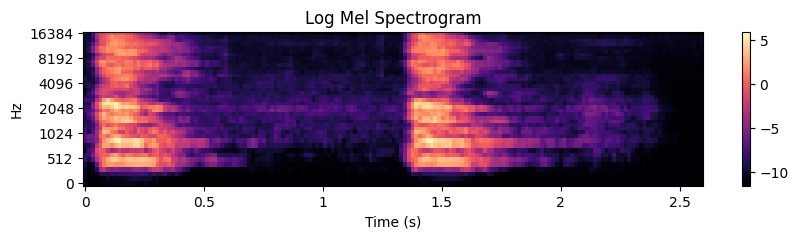

In [261]:
log_mel_spec = (melspec + 0.00001).log()
spec_liro(melspec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Mel Spectrogram")
spec_liro(log_mel_spec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Log Mel Spectrogram")

## Normalization

We often want to normalize spectrograms by dataset mean and variance. Below we use approximated mean (-4.5) and standard deviation (5). However, running through the dataset and calculating mean and variance is the usual way to go.

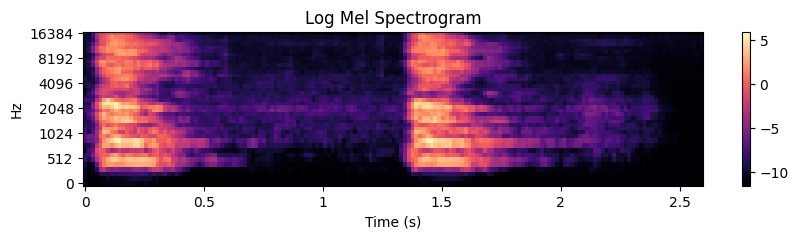

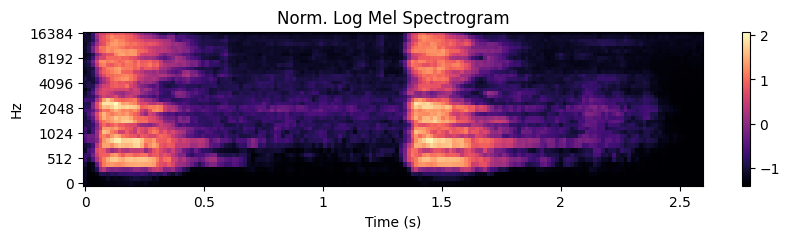

In [262]:
norm_log_mel_spec = (log_mel_spec + 4.5) / 5.
spec_liro(log_mel_spec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Log Mel Spectrogram")
spec_liro(norm_log_mel_spec.squeeze().numpy(), sr, x_is_mel_spec=True, convert_to_db=False, title="Norm. Log Mel Spectrogram")

### What to do with a normalized log mel spectrogram?

Use your favourite vision architecture and treat the normalized log mel spectrogram as an image with a single input channel.

## Example Pipeline on GitHub



# Questions 

* Do you feel comfortable with today's content?
* Do you have computing resources available? Do you need resources from us?
* \<your questions\>

## Your Reports